## Lập trình xử lý dữ liệu - Nhóm 7: Đánh đâu lỗ đó
### Notebook Xử lý dữ liệu cơ bản
---

### Reading and Filtering Stock Data: Processing CSV Files and Refining Data for Analysis

In [199]:
import pandas as pd
import numpy as np
import json 
from dateutil.parser import isoparser

posts_df = pd.read_csv("cleaned_posts.csv")
replies_df = pd.read_csv('cleaned_replies.csv')


posts_df.head(3)

postID                                    originalContent  \
0  29104030                                          Vkl luôn    
1  29104026  Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...   
2  29104024            Tăng 1 phát bằng vn làm hai mấy năm :))   

                            date link  sentiment  totalLikes  totalReplies  \
0  2024-11-06T21:39:23.267+07:00  NaN          0           1             0   
1   2024-11-06T21:39:05.22+07:00  NaN          0           0             0   
2  2024-11-06T21:39:04.077+07:00  NaN          0          12             2   

   replyToPostID                          taggedSymbols     username  \
0            NaN  [{'symb': '^DJI', 'price': 43496.43}]        Hoàng   
1            NaN                                     []      Datbg10   
2            NaN  [{'symb': '^DJI', 'price': 43506.86}]  Trung Tuyến   

                                 userid  totalImages  totalSymbols  
0  5ededf24-12f7-41d9-b390-08ff631fc275            0             1  
1  73778567-ec61-43eb-b3a0-b4a651b8bd3f            0             0  
2  5d597f38-3b24-4f40-952c-2b3f9be8e7d5            0             1

### Data Type Conversion and Data Cleaning for Post Analysis

In [200]:
# Convert data type from 'object' to a Python string
posts_df['taggedSymbols'] = posts_df['taggedSymbols'].astype("string")
posts_df['postID'] = posts_df['postID'].astype('string')
posts_df['originalContent'] = posts_df['originalContent'].astype("string")
posts_df['link'] = posts_df['link'].astype("string")

posts_df['sentiment'] = posts_df['sentiment'].astype('string')
posts_df['sentiment'] = posts_df['sentiment'].map({'1' : 'positive', '0' : 'neutral', '-1' : 'negative'})

posts_df['totalLikes'] = pd.to_numeric(posts_df['totalLikes'], errors='coerce').astype('Int64')
posts_df['totalReplies'] = pd.to_numeric(posts_df['totalReplies'], errors='coerce').astype('Int64')

posts_df['date'] = posts_df['date'].astype("string")
posts_df['date'] = posts_df['date'].apply(lambda x: isoparser().isoparse(x) if pd.notnull(x) else pd.NaT)


posts_df['totalImages'] = pd.to_numeric(posts_df['totalImages'], errors='coerce').astype('Int64')
posts_df['totalSymbols'] = pd.to_numeric(posts_df['totalSymbols'], errors = 'coerce').astype('Int64')

posts_df['replyToPostID'] = posts_df['replyToPostID'].astype("string")
posts_df['username'] = posts_df['username'].astype("string")
posts_df['userid'] = posts_df['userid'].astype('string')

 
# Check the data type
print(posts_df.dtypes)


postID                                    string[python]
originalContent                           string[python]
date               datetime64[ns, tzoffset(None, 25200)]
link                                      string[python]
sentiment                                         object
totalLikes                                         Int64
totalReplies                                       Int64
replyToPostID                             string[python]
taggedSymbols                             string[python]
username                                  string[python]
userid                                    string[python]
totalImages                                        Int64
totalSymbols                                       Int64
dtype: object


### Extracting Price and Symbol Information from Tagged Symbols Data

In [201]:
def json_to_dict(x):
    try:
        data = json.loads(x.replace("'", '"'))
        return data
    except json.JSONDecodeError:
        return None
 
posts_df['taggedSymbols'] = posts_df['taggedSymbols'].apply(json_to_dict)  
posts_df = posts_df.explode('taggedSymbols', ignore_index = True)

In [204]:
posts_df['taggedSymbols']

0           {'symb': '^DJI', 'price': 43496.43}
1                                           NaN
2           {'symb': '^DJI', 'price': 43506.86}
3         {'symb': 'VNINDEX', 'price': 1261.28}
4           {'symb': '^DJI', 'price': 43499.54}
                          ...                  
487263           {'symb': 'GVR', 'price': 34.0}
487264          {'symb': 'DIG', 'price': 22.75}
487265          {'symb': 'FPT', 'price': 131.3}
487266           {'symb': 'OIL', 'price': 13.9}
487267           {'symb': 'NKG', 'price': 20.7}
Name: taggedSymbols, Length: 487268, dtype: object

In [207]:
def extract_price(x):
    if isinstance(x, dict) and 'price' in x:
        return x['price']
    return None

posts_df['price'] = posts_df['taggedSymbols'].apply(extract_price)

def extract_symbol(x):
    if isinstance(x, dict) and 'symb' in x:
        return x['symb']
    return None
posts_df['symbol'] = posts_df['taggedSymbols'].apply(extract_symbol)  
posts_df.head(2)   

postID                                    originalContent  \
0  29104030                                          Vkl luôn    
1  29104026  Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...   

                              date  link sentiment  totalLikes  totalReplies  \
0 2024-11-06 21:39:23.267000+07:00  <NA>   neutral           1             0   
1 2024-11-06 21:39:05.220000+07:00  <NA>   neutral           0             0   

  replyToPostID                        taggedSymbols username  \
0          <NA>  {'symb': '^DJI', 'price': 43496.43}    Hoàng   
1          <NA>                                  NaN  Datbg10   

                                 userid  totalImages  totalSymbols     price  \
0  5ededf24-12f7-41d9-b390-08ff631fc275            0             1  43496.43   
1  73778567-ec61-43eb-b3a0-b4a651b8bd3f            0             0       NaN   

  symbol  
0   ^DJI  
1   None

#### Handling Missing replyToPostID Values by Mapping Post-Reply Relationships from replies_df

In [208]:
replies_df.head(3)

postID                                    originalContent  \
0  29100636  Bác có thể đưa ra kịch bản rằng : Họ sai!\nSố ...   
1  29100614  Sao số liệu tự doanh mỗi nơi mỗi khác nhỉ, nay...   
2  29100602  hiện basic cạn cả cung cả cầu. Nn thoát basic ...   

                            date link  sentiment  isTop  isExpertIdea  \
0  2024-11-06T16:37:32.923+07:00  NaN          0  False         False   
1  2024-11-06T16:35:32.107+07:00  NaN          0  False         False   
2  2024-11-06T16:34:42.663+07:00  NaN          0  False         False   

   totalLikes  totalReplies  replyToPostID  referToPostID taggedSymbols  \
0           1             0       29099549            NaN            []   
1           1             0       29099549            NaN            []   
2           0             0       29099549            NaN            []   

          username                                userid  totalImages  \
0              NDC  028e4d25-5631-4f3f-8f72-235eabaef9ba            0   
1            Alex   d0a457ea-b787-4263-bdd1-0e8d0bfc63d9            0   
2  Upgrading to Fo  3cc4dffe-ac35-4ac8-95d8-6eb677353d5d            0   

   totalSymbols  
0             0  
1             0  
2             0

### Creating a Post-Reply Dictionary and Updating Replies Information in the DataFrame

In [209]:
#Create the post_reply_dict from replies_df
post_reply_dict = dict(zip(replies_df['postID'], replies_df['replyToPostID']))

# set 'replyToPostID' in posts_df to the value from the dictionary if it exists
posts_df['replyToPostID'] = posts_df['postID'].map(post_reply_dict)

#Increment 'totalReplies' for posts that are being replied to
posts_df.loc[posts_df['replyToPostID'].notna(), 'totalReplies'] += 1

        
posts_df.head(2)

postID                                    originalContent  \
0  29104030                                          Vkl luôn    
1  29104026  Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...   

                              date  link sentiment  totalLikes  totalReplies  \
0 2024-11-06 21:39:23.267000+07:00  <NA>   neutral           1             0   
1 2024-11-06 21:39:05.220000+07:00  <NA>   neutral           0             0   

   replyToPostID                        taggedSymbols username  \
0            NaN  {'symb': '^DJI', 'price': 43496.43}    Hoàng   
1            NaN                                  NaN  Datbg10   

                                 userid  totalImages  totalSymbols     price  \
0  5ededf24-12f7-41d9-b390-08ff631fc275            0             1  43496.43   
1  73778567-ec61-43eb-b3a0-b4a651b8bd3f            0             0       NaN   

  symbol  
0   ^DJI  
1   None

In [210]:
print(replies_df['totalReplies'].unique())
print(replies_df['taggedSymbols'].unique())
print(replies_df['isTop'].unique())
print(replies_df['isExpertIdea'].unique())
print(replies_df['sentiment'].unique())
print(replies_df['totalSymbols'].unique())
print(replies_df['referToPostID'].unique())


[0]
['[]']
[False]
[False]
[0]
[0]
[nan]


#### Since data in these columns are 0/False/nan/[] only, we remove these columns

In [211]:
replies_df.drop(['totalReplies', 'taggedSymbols', 'isTop', 'isExpertIdea', 'sentiment', 'totalSymbols', 'referToPostID'], axis = 1, inplace = True)
replies_df.head(5)

postID                                    originalContent  \
0  29100636  Bác có thể đưa ra kịch bản rằng : Họ sai!\nSố ...   
1  29100614  Sao số liệu tự doanh mỗi nơi mỗi khác nhỉ, nay...   
2  29100602  hiện basic cạn cả cung cả cầu. Nn thoát basic ...   
3  29100595                      :)) bác lại chuẩn bài quá đó.   
4  29100584  rõ ràng phải có chữ NẾU, lỡ ko đc còn có cái m...   

                            date link  totalLikes  replyToPostID  \
0  2024-11-06T16:37:32.923+07:00  NaN           1       29099549   
1  2024-11-06T16:35:32.107+07:00  NaN           1       29099549   
2  2024-11-06T16:34:42.663+07:00  NaN           0       29099549   
3   2024-11-06T16:34:04.07+07:00  NaN           0       29099549   
4    2024-11-06T16:33:33.9+07:00  NaN           0       29099549   

          username                                userid  totalImages  
0              NDC  028e4d25-5631-4f3f-8f72-235eabaef9ba            0  
1            Alex   d0a457ea-b787-4263-bdd1-0e8d0bfc63d9            0  
2  Upgrading to Fo  3cc4dffe-ac35-4ac8-95d8-6eb677353d5d            0  
3              NDC  028e4d25-5631-4f3f-8f72-235eabaef9ba            0  
4         Tùng Cận  2b323870-af46-471a-aee7-bd28a23990e2            0

In [212]:
replies_df['postID'] = replies_df['postID'].astype("string")
replies_df['originalContent'] = replies_df['originalContent'].astype("string")
replies_df['link'] = replies_df['link'].astype('string')
replies_df['username'] = replies_df['username'].astype('string')
replies_df['replyToPostID'] = replies_df['replyToPostID'].astype('string')
replies_df['userid'] = replies_df['userid'].astype('string')



replies_df['totalLikes'] = pd.to_numeric(replies_df['totalLikes'], errors = 'coerce').astype("int64")
replies_df['totalLikes'] = pd.to_numeric(replies_df['totalLikes'], errors = 'coerce').astype('int64')


replies_df['date'] = replies_df['date'].astype('string')
replies_df['date'] = replies_df['date'].apply(lambda x : isoparser().isoparse(x) if pd.notnull(x) else pd.NaT)

print(replies_df.dtypes)

postID                                    string[python]
originalContent                           string[python]
date               datetime64[ns, tzoffset(None, 25200)]
link                                      string[python]
totalLikes                                         int64
replyToPostID                             string[python]
username                                  string[python]
userid                                    string[python]
totalImages                                        int64
dtype: object


---
### Perform Basic Calculations and Statistics

#### Rank the Most Mentioned Companies/Brands

In [213]:
company_occurrences = posts_df['symbol'].value_counts()
company_occurrences.head(20)
posts_df


postID                                    originalContent  \
0       29104030                                          Vkl luôn    
1       29104026  Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...   
2       29104024            Tăng 1 phát bằng vn làm hai mấy năm :))   
3       29104021                            Má đáng full tiền...đau   
4       29104019                                     Gap khủng long   
...          ...                                                ...   
487263  28008015                              **** nhau quá đáng vc   
487264  28008013           CON NÀY NÓ CHẾT DẬP CHẾT DỤI QUÁ CƠ, HIC   
487265  28008006                         Múc ! Rũ để vượt đỉnh nào    
487266  28008001  Đừng mong giá rẻ hơn mấy ní ạ , đỏ ko mua xanh...   
487267  28007995  nước ngoài mua 600 cổ rồi kia kìa mấy con dời ...   

                                   date  link sentiment  totalLikes  \
0      2024-11-06 21:39:23.267000+07:00  <NA>   neutral           1   
1      2024-11-06 21:39:05.220000+07:00  <NA>   neutral           0   
2      2024-11-06 21:39:04.077000+07:00  <NA>   neutral          12   
3      2024-11-06 21:38:52.277000+07:00  <NA>   neutral           0   
4      2024-11-06 21:38:49.990000+07:00  <NA>   neutral           2   
...                                 ...   ...       ...         ...   
487263 2024-09-06 09:54:04.067000+07:00  <NA>   neutral           2   
487264 2024-09-06 09:54:03.033000+07:00  <NA>   neutral           0   
487265 2024-09-06 09:53:56.957000+07:00  <NA>   neutral           3   
487266 2024-09-06 09:53:50.097000+07:00  <NA>   neutral           3   
487267 2024-09-06 09:53:45.330000+07:00  <NA>   neutral           2   

        totalReplies  replyToPostID                          taggedSymbols  \
0                  0            NaN    {'symb': '^DJI', 'price': 43496.43}   
1                  0            NaN                                    NaN   
2                  2            NaN    {'symb': '^DJI', 'price': 43506.86}   
3                  1            NaN  {'symb': 'VNINDEX', 'price': 1261.28}   
4                  0            NaN    {'symb': '^DJI', 'price': 43499.54}   
...              ...            ...                                    ...   
487263             0            NaN         {'symb': 'GVR', 'price': 34.0}   
487264             0            NaN        {'symb': 'DIG', 'price': 22.75}   
487265             0            NaN        {'symb': 'FPT', 'price': 131.3}   
487266             6            NaN         {'symb': 'OIL', 'price': 13.9}   
487267             2            NaN         {'symb': 'NKG', 'price': 20.7}   

                             username                                userid  \
0                               Hoàng  5ededf24-12f7-41d9-b390-08ff631fc275   
1                             Datbg10  73778567-ec61-43eb-b3a0-b4a651b8bd3f   
2                         Trung Tuyến  5d597f38-3b24-4f40-952c-2b3f9be8e7d5   
3                          Duc Nguyen  225659c6-cf18-4e93-aa39-a294bae5b784   
4                            BINH NHI  da8ebfa2-9cd5-4dbf-84cd-9567f694f681   
...                               ...                                   ...   
487263                            NTH  eed1b1ff-a87b-43a8-acf3-60605631cd8e   
487264                       Xuân Phú  69659543-c04f-4f3d-9b7b-2543d3f4e4a7   
487265                        Hồ Đồng  8087c7d2-960f-4160-b0c0-4dc782d02a12   
487266              Diệt Chim Lợn Chó  f2133134-296f-4572-90fc-6cb4a81cf7d6   
487267  VNINDEX SÒNG BẠC CẤP QUỐC GIA  10e5f0c7-909f-438f-9d74-f85cf881a5f4   

        totalImages  totalSymbols     price   symbol  
0                 0             1  43496.43     ^DJI  
1                 0             0       NaN     None  
2                 0             1  43506.86     ^DJI  
3                 1             1   1261.28  VNINDEX  
4                 0             1  43499.54     ^DJI  
...             ...           ...       ...      ...  
487263            0             1

### Statistics on the Number of Positive, Negative, and Neutral Posts for Each Brand

In [214]:
stock_symbols_analysis = posts_df.groupby('symbol').agg(
    TotalPosts = ('sentiment', 'count'),
    NumberOFPositivePosts = ('sentiment', lambda x : (x == 'positive').sum()),
    NumberOFNegativePosts = ("sentiment", lambda x : (x == 'negative').sum()),
    NumberOfNeutralPosts = ('sentiment', lambda x : (x == 'neutral').sum()),
).reset_index()


    
stock_symbols_analysis['PositiveRatio'] = stock_symbols_analysis['NumberOFPositivePosts'] / stock_symbols_analysis['NumberOFNegativePosts']
stock_symbols_analysis['PositiveRatio'] = stock_symbols_analysis['PositiveRatio'].replace([np.inf, -np.inf, np.nan], 0)
stock_symbols_analysis = stock_symbols_analysis.round(2)

average_total_posts = round(stock_symbols_analysis['TotalPosts'].mean(), 2)
average_total_positive_posts = round(stock_symbols_analysis['NumberOFPositivePosts'].mean(), 2)
average_total_negative_posts = round(stock_symbols_analysis['NumberOFNegativePosts'].mean(), 2)
average_positive_ratio = round(stock_symbols_analysis['PositiveRatio'].mean(), 2)


# Print all the average values
print(f"Average Total Posts: {average_total_posts}")
print(f"Average Total Positive Posts: {average_total_positive_posts}")
print(f"Average Total Negative Posts: {average_total_negative_posts}")
print(f"Average Positive Ratio: {average_positive_ratio}")

stock_symbols_analysis.sort_values(['NumberOFPositivePosts', 'NumberOFNegativePosts', 'PositiveRatio'], ascending = [False, False ,False]).head(2)



Average Total Posts: 324.28
Average Total Positive Posts: 61.17
Average Total Negative Posts: 15.59
Average Positive Ratio: 1.52


symbol  TotalPosts  NumberOFPositivePosts  NumberOFNegativePosts  \
1382  VNINDEX       55258                   8919                   3518   
624       HPG       13317                   3204                    582   

      NumberOfNeutralPosts  PositiveRatio  
1382                 42821           2.54  
624                   9531           5.51

In [215]:
popular_brand_list = stock_symbols_analysis.loc[stock_symbols_analysis['TotalPosts'] > 3000]['symbol']
popular_brand_list = popular_brand_list.tolist()
print(popular_brand_list)

['$BTC', 'ACB', 'BSR', 'CEO', 'CTG', 'DBC', 'DCM', 'DIG', 'DXG', 'EIB', 'FPT', 'FTS', 'HCM', 'HPG', 'HSG', 'MBB', 'MBS', 'MSB', 'MSN', 'MWG', 'NKG', 'NVL', 'PDR', 'SHB', 'SSI', 'STB', 'TCB', 'TCH', 'TPB', 'VCI', 'VHM', 'VIC', 'VIX', 'VN30', 'VN30F1M', 'VND', 'VNINDEX', 'VPB', 'VRE', '^DJI']


### VNIDEX analysis

In [216]:
VNINDEX_df = posts_df.loc[posts_df['symbol'] == 'VNINDEX']
VNINDEX_df = VNINDEX_df.sort_values(by = 'date', ascending = True)
VNINDEX_df['date'] = VNINDEX_df['date'].dt.date
VNINDEX_df.head(2)


postID                                    originalContent  \
487246  28008039                       Toàn hàng ngon mà bỏ lỡ  nhỉ   
487241  28008058  Tiền đi đâu hết rồi. Thanh khoản yếu thế này c...   

              date  link sentiment  totalLikes  totalReplies  replyToPostID  \
487246  2024-09-06  <NA>   neutral           0             2            NaN   
487241  2024-09-06  <NA>  negative           0             0            NaN   

                                taggedSymbols               username  \
487246  {'symb': 'VNINDEX', 'price': 1268.51}            Slang High    
487241  {'symb': 'VNINDEX', 'price': 1268.58}  Hành Trình Về Bờ 🧑🏻‍🎤   

                                      userid  totalImages  totalSymbols  \
487246  6727b9f2-e137-43e6-9b50-f73d585b4463            0             3   
487241  8afad925-61c1-4ee3-8aa0-1890ad019fbe            0             1   

          price   symbol  
487246  1268.51  VNINDEX  
487241  1268.58  VNINDEX

### Aggregating Posts and Price Data for VNINDEX by Date

In [217]:
VNINDEX_analyse = VNINDEX_df.groupby(['date']).agg(
    NumberOfPosts=('postID', 'count'),
    NumberOfNegativePosts=('sentiment', lambda x: (x == 'negative').sum()),
    NumberOfPositivePosts=('sentiment', lambda x: (x == 'positive').sum()),
    price=('price', 'mean')  # Aggregation function for 'price'
).reset_index()

# Display the result
VNINDEX_analyse.head(20)


date  NumberOfPosts  NumberOfNegativePosts  NumberOfPositivePosts  \
0   2024-09-06            707                     48                     80   
1   2024-09-07            113                      6                     24   
2   2024-09-08            120                      6                     29   
3   2024-09-09            891                     51                    148   
4   2024-09-10           1203                     83                    144   
5   2024-09-11           1131                     94                    140   
6   2024-09-12            953                     66                    159   
7   2024-09-13           1028                     52                    158   
8   2024-09-14             94                      2                     19   
9   2024-09-15            150                      7                     37   
10  2024-09-16           1182                    108                    153   
11  2024-09-17           1247                     58                    227   
12  2024-09-18            949                     43                    198   
13  2024-09-19            992                     43                    228   
14  2024-09-20           1225                     72                    192   
15  2024-09-21            107                      5                     23   
16  2024-09-22            137                      4                     40   
17  2024-09-23            838                     57                    171   
18  2024-09-24           1093                     57                    246   
19  2024-09-25           1105                     30                    277   

          price  
0   1268.913918  
1   1273.960000  
2   1273.695417  
3   1268.054759  
4   1260.192934  
5   1251.090840  
6   1257.005960  
7   1251.985525  
8   1251.710000  
9   1251.969267  
10  1244.812530  
11  1247.328885  
12  1265.148609  
13  1268.380847  
14  1274.941045  
15  1272.040000  
16  1272.040000  
17  1270.480871  
18  1271.897173  
19  1284.744072

### Visualization of VNINDEX Data

<Figure size 1200x800 with 0 Axes>

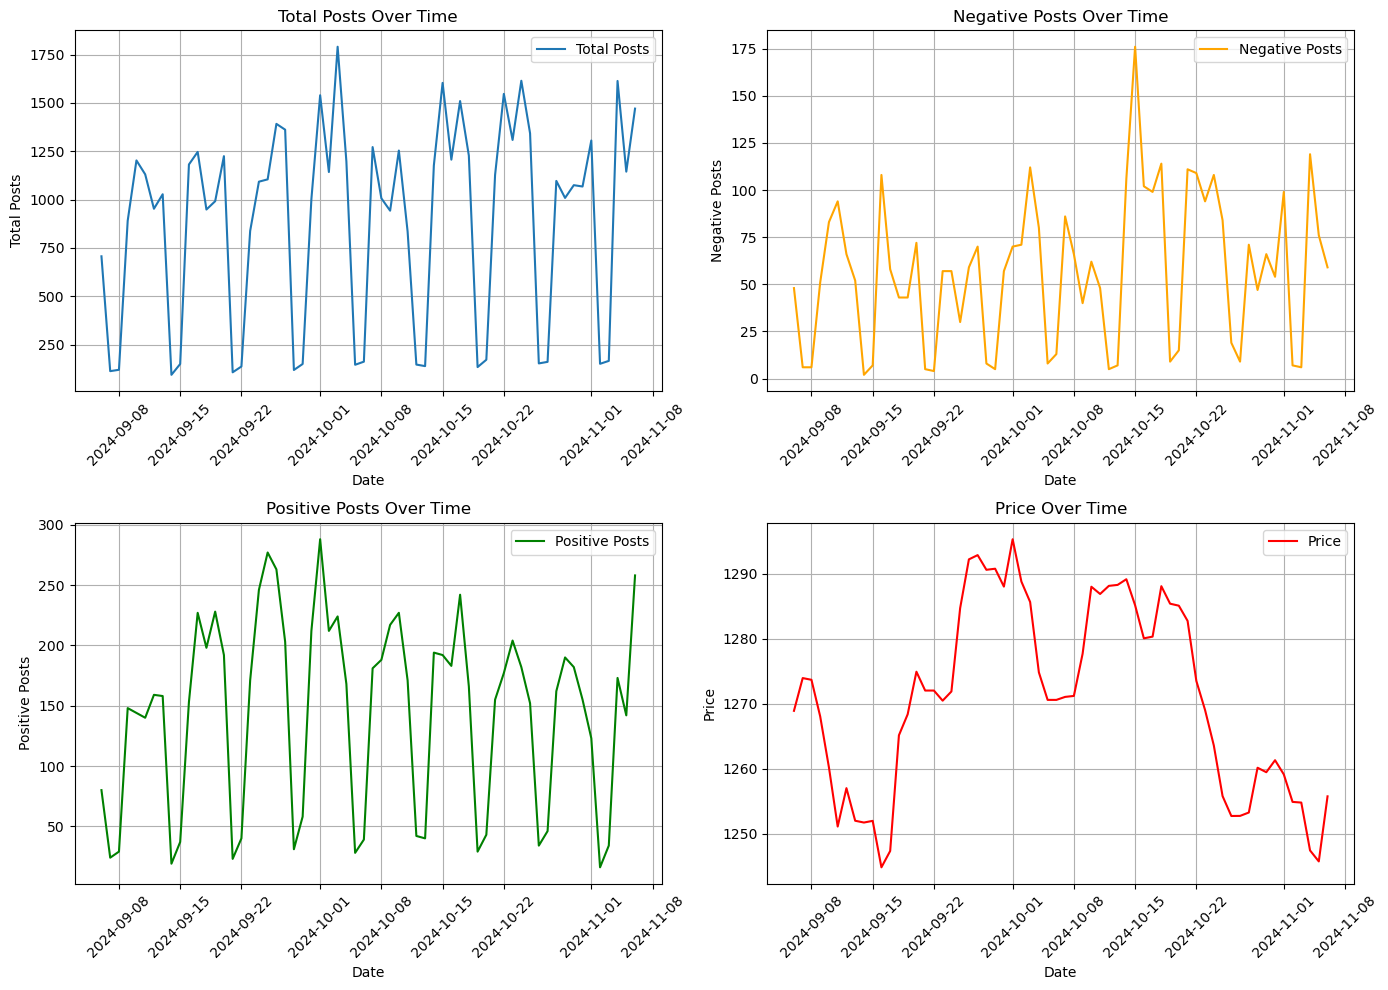

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))


# Set up a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot each variable in a separate subplot using the raw data
axes[0, 0].plot(VNINDEX_analyse['date'], VNINDEX_analyse['NumberOfPosts'], label='Total Posts')
axes[0, 0].set_title("Total Posts Over Time")
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Posts')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].plot(VNINDEX_analyse['date'], VNINDEX_analyse['NumberOfNegativePosts'], label='Negative Posts', color='orange')
axes[0, 1].set_title("Negative Posts Over Time")
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Negative Posts')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].plot(VNINDEX_analyse['date'], VNINDEX_analyse['NumberOfPositivePosts'], label='Positive Posts', color='green')
axes[1, 0].set_title("Positive Posts Over Time")
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Positive Posts')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].plot(VNINDEX_analyse['date'], VNINDEX_analyse['price'], label='Price', color='red')
axes[1, 1].set_title("Price Over Time")
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Price')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [219]:
import seaborn as sns
# Calculate the average and standard deviation of the VNINDEX price
average_vnindex_price = VNINDEX_analyse['price'].mean()
standard_price_deviation = VNINDEX_analyse['price'].std()

# Calculate the correlation between different post categories and the price
correlation_positive_price = (VNINDEX_analyse['NumberOfPositivePosts'] / VNINDEX_analyse['NumberOfPosts']).corr(VNINDEX_analyse['price'])
correlation_negative_price = (VNINDEX_analyse['NumberOfNegativePosts'] / VNINDEX_analyse['NumberOfPosts']).corr(VNINDEX_analyse['price'])
correlation_posts_price = (VNINDEX_analyse['NumberOfPosts']).corr(VNINDEX_analyse['price'])

# Calculate percentage change for posts and price
VNINDEX_analyse['posts_pct_change'] = VNINDEX_analyse['NumberOfPosts'].pct_change() 
VNINDEX_analyse['price_pct_change'] = VNINDEX_analyse['price'].pct_change() * 100


# Calculate correlation between percentage change in posts and price
correlation_pct_change = VNINDEX_analyse['posts_pct_change'].corr(VNINDEX_analyse['price_pct_change'])

# Print the results with formatting
print(f"Average VNINDEX Price: {average_vnindex_price:.2f}")
print(f"Standard Deviation of Price: {standard_price_deviation:.2f}")
print(f"Correlation between Positive Posts and Price: {correlation_positive_price:.2f}")
print(f"Correlation between Negative Posts and Price: {correlation_negative_price:.2f}")
print(f"Correlation between the Number of Posts and Price: {correlation_posts_price:.2f}")
print(f"Correlation between Percentage Change of Posts and Price: {correlation_pct_change:.2f}")



Average VNINDEX Price: 1270.77
Standard Deviation of Price: 14.54
Correlation between Positive Posts and Price: 0.31
Correlation between Negative Posts and Price: -0.02
Correlation between the Number of Posts and Price: 0.03
Correlation between Percentage Change of Posts and Price: -0.18


### Visualization the correlation of Percentage Change in Price vs Number of Posts

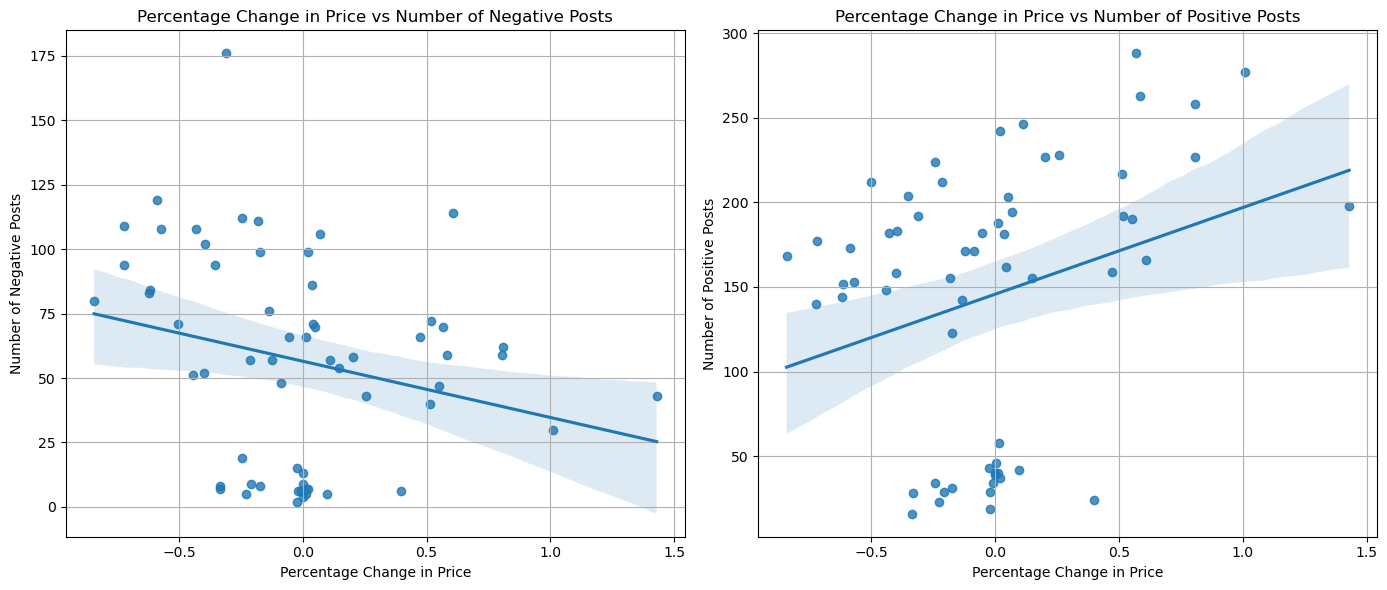

In [220]:
import seaborn as sns

import seaborn as sns

# Set up a 1x2 grid for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Number of Negative Posts
sns.regplot(x='price_pct_change', y='NumberOfNegativePosts', data=VNINDEX_analyse, ax=axes[0])
axes[0].set_title('Percentage Change in Price vs Number of Negative Posts')
axes[0].set_xlabel('Percentage Change in Price')
axes[0].set_ylabel('Number of Negative Posts')
axes[0].grid(True)

# Plot for Number of Positive Posts
sns.regplot(x='price_pct_change', y='NumberOfPositivePosts', data=VNINDEX_analyse, ax=axes[1])
axes[1].set_title('Percentage Change in Price vs Number of Positive Posts')
axes[1].set_xlabel('Percentage Change in Price')
axes[1].set_ylabel('Number of Positive Posts')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

In [221]:
VNINDEX_analyse['price_change'] = VNINDEX_analyse['price'].diff()
correlation_price_change_posts = VNINDEX_analyse['price_change'].abs().corr(VNINDEX_analyse['NumberOfPosts'])
correlation_price_change_negative_posts = VNINDEX_analyse['price_change'].abs().corr(VNINDEX_analyse['NumberOfNegativePosts'])
correlation_price_change_positive_posts = VNINDEX_analyse['price_change'].corr(VNINDEX_analyse['NumberOfPositivePosts'])

print(f"Correlation between Price Change and Number of Posts: {correlation_price_change_posts:.2f}")
print(f"Correlation between Price Change and Number of Negative Posts: {correlation_price_change_negative_posts:.2f}")
print(f"Correlation between Price Change and Number of Positive Posts: {correlation_price_change_positive_posts:.2f}")

Correlation between Price Change and Number of Posts: 0.43
Correlation between Price Change and Number of Negative Posts: 0.29
Correlation between Price Change and Number of Positive Posts: 0.28


### Categorizing Days Based on Price Change and Analyzing Post Data

In [222]:
# Define thresholds
stability_threshold = 0.25  # Stable days with minimal change
slight_change_threshold = 2  # Slight change days

# Categorize days based on price change
VNINDEX_analyse['price_category'] = 'Stable'
VNINDEX_analyse.loc[(VNINDEX_analyse['price_change'] > stability_threshold) & 
                    (VNINDEX_analyse['price_change'] <= slight_change_threshold), 'price_category'] = 'Slight Change'
VNINDEX_analyse.loc[VNINDEX_analyse['price_change'] > 4, 'price_category'] = 'Significant Increase'
VNINDEX_analyse.loc[VNINDEX_analyse['price_change'] < -4, 'price_category'] = 'Significant Decrease'

# Calculate average number of posts for each category
avg_posts = VNINDEX_analyse.groupby('price_category')['NumberOfPosts'].mean()
avg_positive_posts = VNINDEX_analyse.groupby('price_category')['NumberOfPositivePosts'].mean()
avg_negative_posts = VNINDEX_analyse.groupby('price_category')['NumberOfNegativePosts'].mean()

# Print the results
print("\nAverage Number of Posts by Price Category:")
for category in avg_posts.index:  # Loop only through existing categories
    print(f"{category} Days:")
    print(f"  - Average Number of Posts: {avg_posts[category]:.2f}")
    print(f"  - Average Number of Positive Posts: {avg_positive_posts[category]:.2f}")
    print(f"  - Average Number of Negative Posts: {avg_negative_posts[category]:.2f}")
    print("")


Average Number of Posts by Price Category:
Significant Decrease Days:
  - Average Number of Posts: 1144.50
  - Average Number of Positive Posts: 151.88
  - Average Number of Negative Posts: 84.12

Significant Increase Days:
  - Average Number of Posts: 1098.50
  - Average Number of Positive Posts: 204.92
  - Average Number of Negative Posts: 55.67

Slight Change Days:
  - Average Number of Posts: 986.22
  - Average Number of Positive Posts: 162.44
  - Average Number of Negative Posts: 61.67

Stable Days:
  - Average Number of Posts: 595.52
  - Average Number of Positive Posts: 102.72
  - Average Number of Negative Posts: 37.96



### Visualization of posts number in different days types using Bar Plot

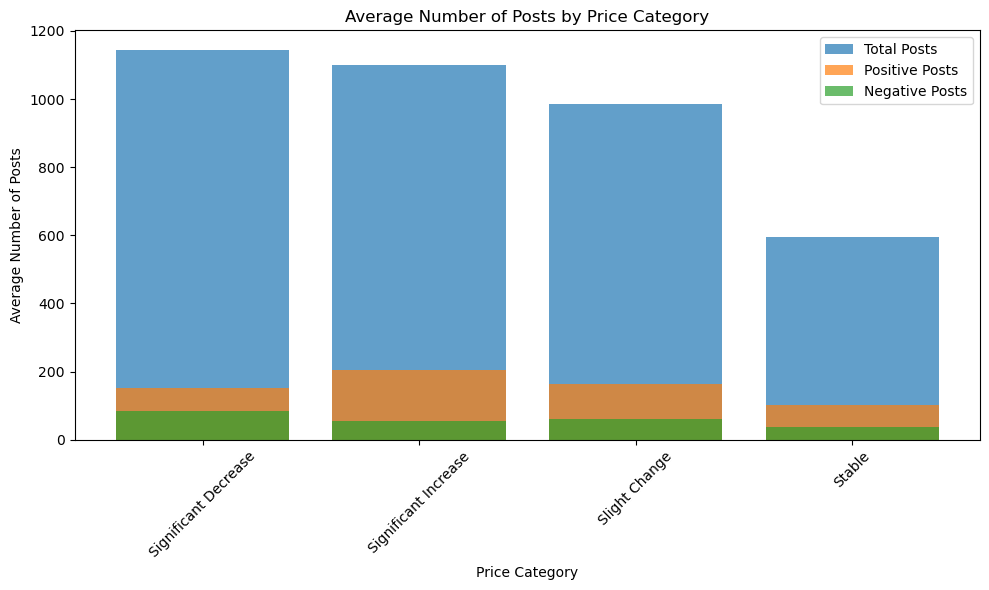

In [223]:
# Plotting average posts per category
categories = avg_posts.index
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the total posts, positive posts, and negative posts
ax.bar(categories, avg_posts, label='Total Posts', alpha=0.7)
ax.bar(categories, avg_positive_posts, label='Positive Posts', alpha=0.7)
ax.bar(categories, avg_negative_posts, label='Negative Posts', alpha=0.7)

ax.set_title('Average Number of Posts by Price Category')
ax.set_xlabel('Price Category')
ax.set_ylabel('Average Number of Posts')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [224]:
posts_df.rename(columns = {'date' : 'time'}, inplace = True)
posts_df.insert(3, 'date', posts_df['time'].dt.date)
posts_df.head(2)

postID                                    originalContent  \
0  29104030                                          Vkl luôn    
1  29104026  Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...   

                              time        date  link sentiment  totalLikes  \
0 2024-11-06 21:39:23.267000+07:00  2024-11-06  <NA>   neutral           1   
1 2024-11-06 21:39:05.220000+07:00  2024-11-06  <NA>   neutral           0   

   totalReplies  replyToPostID                        taggedSymbols username  \
0             0            NaN  {'symb': '^DJI', 'price': 43496.43}    Hoàng   
1             0            NaN                                  NaN  Datbg10   

                                 userid  totalImages  totalSymbols     price  \
0  5ededf24-12f7-41d9-b390-08ff631fc275            0             1  43496.43   
1  73778567-ec61-43eb-b3a0-b4a651b8bd3f            0             0       NaN   

  symbol  
0   ^DJI  
1   None

In [225]:
posts_df['word_count'] = posts_df['originalContent'].fillna('').str.split().str.len()
posts_df.head(2)

postID                                    originalContent  \
0  29104030                                          Vkl luôn    
1  29104026  Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...   

                              time        date  link sentiment  totalLikes  \
0 2024-11-06 21:39:23.267000+07:00  2024-11-06  <NA>   neutral           1   
1 2024-11-06 21:39:05.220000+07:00  2024-11-06  <NA>   neutral           0   

   totalReplies  replyToPostID                        taggedSymbols username  \
0             0            NaN  {'symb': '^DJI', 'price': 43496.43}    Hoàng   
1             0            NaN                                  NaN  Datbg10   

                                 userid  totalImages  totalSymbols     price  \
0  5ededf24-12f7-41d9-b390-08ff631fc275            0             1  43496.43   
1  73778567-ec61-43eb-b3a0-b4a651b8bd3f            0             0       NaN   

  symbol  word_count  
0   ^DJI           2  
1   None          15

In [226]:

posts_analyze = posts_df.groupby('date').agg(
    number_of_posts = ('postID', 'count'),
    number_of_positive_posts = ('sentiment', lambda x : (x == 'positive').sum()),
    number_of_negative_posts = ('sentiment', lambda x : (x == 'negative').sum()),
    average_posts_len = ('word_count', 'mean'),
    total_likes = ('totalLikes', 'sum'),
    total_replies = ('totalReplies', 'sum'),
    stock_symbols_mentioned = ('symbol', lambda x : x.nunique())
).reset_index()

posts_analyze = posts_analyze.round(2)
posts_analyze.head(2)


date  number_of_posts  number_of_positive_posts  \
0  2024-09-06             6594                       886   
1  2024-09-07             1242                       286   

   number_of_negative_posts  average_posts_len  total_likes  total_replies  \
0                       341              50.33        10468          14175   
1                        54              82.03         2786           4086   

   stock_symbols_mentioned  
0                      392  
1                      230

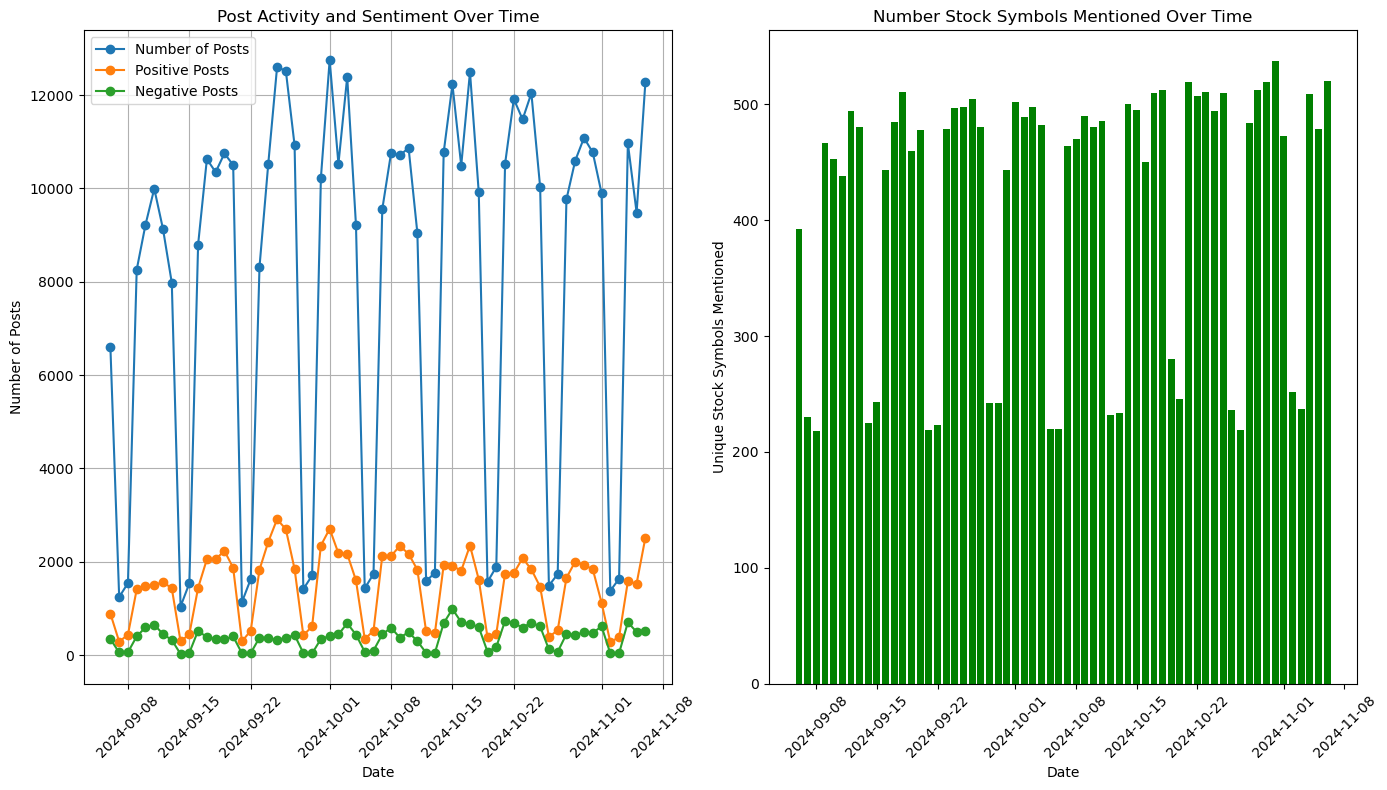

In [227]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Subplot 1: Number of Posts, Positive Posts, Negative Posts over time
plt.subplot(1, 2, 1)
plt.plot(posts_analyze['date'], posts_analyze['number_of_posts'], label='Number of Posts', marker='o')
plt.plot(posts_analyze['date'], posts_analyze['number_of_positive_posts'], label='Positive Posts', marker='o')
plt.plot(posts_analyze['date'], posts_analyze['number_of_negative_posts'], label='Negative Posts', marker='o')
plt.title('Post Activity and Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)


# Subplot 2: Stock Symbols Mentioned over time
plt.subplot(1, 2, 2)
plt.bar(posts_analyze['date'], posts_analyze['stock_symbols_mentioned'], color='green')
plt.title('Number Stock Symbols Mentioned Over Time')
plt.xlabel('Date')
plt.ylabel('Unique Stock Symbols Mentioned')
plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [228]:
sentiment_analysis = posts_df.groupby('sentiment').agg(
    number_of_posts = ('postID', 'count'),
    average_posts_len = ('word_count', 'mean'),
    total_likes = ('totalLikes', 'sum'),
    total_replies = ('totalReplies', 'sum'),
    stock_symbols_mentioned = ('symbol', lambda x: x.nunique())
).reset_index()

sentiment_analysis

sentiment  number_of_posts  average_posts_len  total_likes  total_replies  \
0  negative            23261          45.149693        41720          73212   
1   neutral           372614          57.393007       609447         838558   
2  positive            91393          98.856729       219205         289075   

   stock_symbols_mentioned  
0                      541  
1                     1372  
2                      943

In [229]:
user_activity = posts_df.groupby('userid').agg(
    userName = ('username', 'first'),
    number_of_posts = ('postID', 'count'),
    average_posts_len = ('word_count', 'mean'),
    total_likes = ('totalLikes', 'sum'),
    total_replies = ('totalReplies', 'sum'),
    stock_symbols_mentioned = ('symbol', lambda x: x.nunique())
).reset_index()




In [230]:
user_activity.sort_values(by = 'number_of_posts', ascending = False, inplace = True)
user_activity = user_activity.round(2)
user_activity.head(3)

userid          userName  \
21137  eef9912f-f5eb-4f32-8cc7-71a214b7d02a        Tư Bản Mẽo   
18053  cbac0965-66d6-4107-bece-83f0bec4cf95        Hồng Nhung   
1475   10789b61-001c-4a54-8b48-4cbe4c90e40a  Sói già VNDIRECT   

       number_of_posts  average_posts_len  total_likes  total_replies  \
21137             1579              42.52         3567           8519   
18053             1567             119.36         3324           1240   
1475              1564             412.51         1700            634   

       stock_symbols_mentioned  
21137                       46  
18053                       93  
1475                       395

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12644 (\N{HANGUL FILLER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


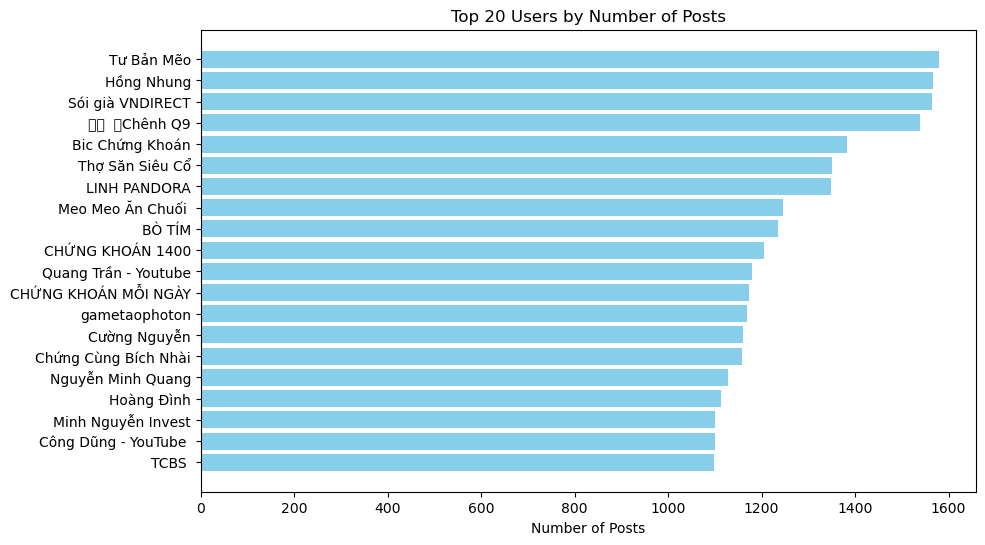

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12644 (\N{HANGUL FILLER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


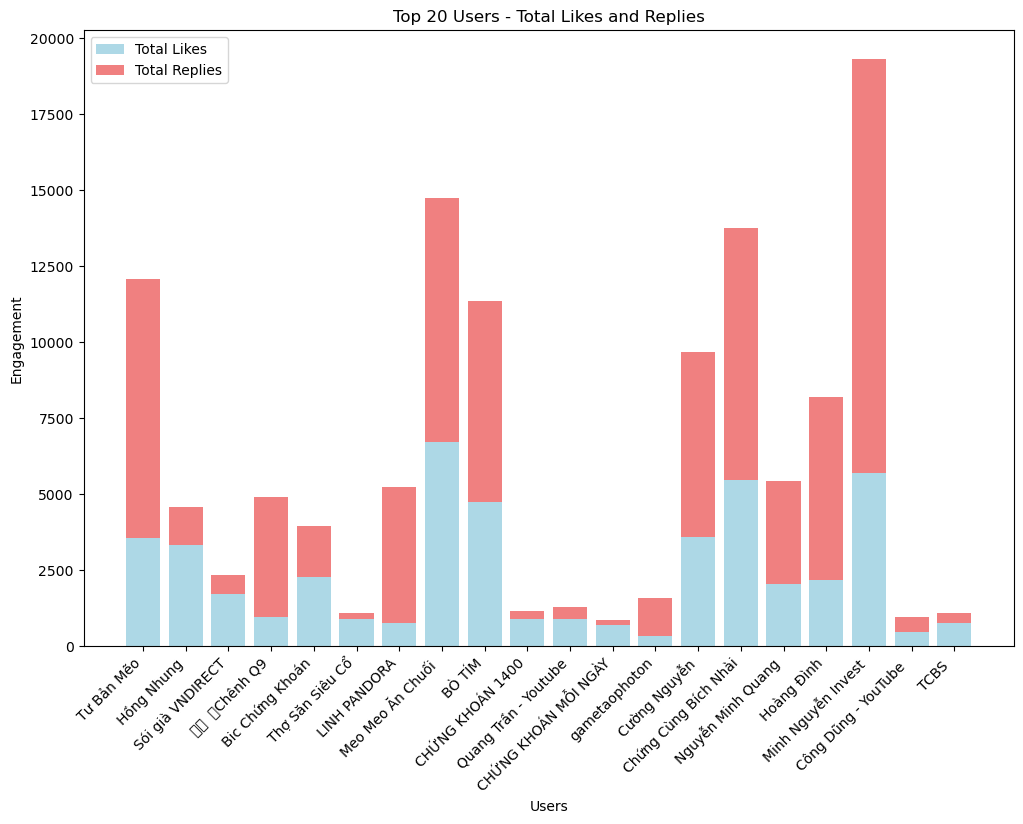

In [231]:
# Select top 20 users by number of posts
top_users = user_activity.nlargest(20, 'number_of_posts')
user_names = top_users['userName']

# Horizontal Bar Chart for `number_of_posts`
plt.figure(figsize=(10, 6))
plt.barh(user_names, top_users['number_of_posts'], color='skyblue')
plt.xlabel('Number of Posts')
plt.title('Top 20 Users by Number of Posts')
plt.gca().invert_yaxis()
plt.show()

# Stacked Bar Chart for `total_likes` and `total_replies`
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(user_names, top_users['total_likes'], label='Total Likes', color='lightblue')
ax.bar(user_names, top_users['total_replies'], bottom=top_users['total_likes'], label='Total Replies', color='lightcoral')

ax.set_xlabel('Users')
ax.set_ylabel('Engagement')
ax.set_title('Top 20 Users - Total Likes and Replies')
plt.xticks(rotation=45, ha='right')
ax.legend()
plt.show()

In [232]:
symbol_mentions_over_time = posts_df.groupby(['date', 'symbol']).agg(
    number_of_mentions = ('symbol', 'count'),
    average_posts_len = ('word_count', 'mean'),
    total_likes = ('totalLikes', 'sum'),
    total_replies = ('totalReplies', 'sum')
).reset_index()

In [233]:
symbol_mentions_over_time.round(2).head(2)

date symbol  number_of_mentions  average_posts_len  total_likes  \
0  2024-09-06   $APT                   1               11.0            0   
1  2024-09-06   $BTC                  70               31.8           83   

   total_replies  
0              0  
1            289

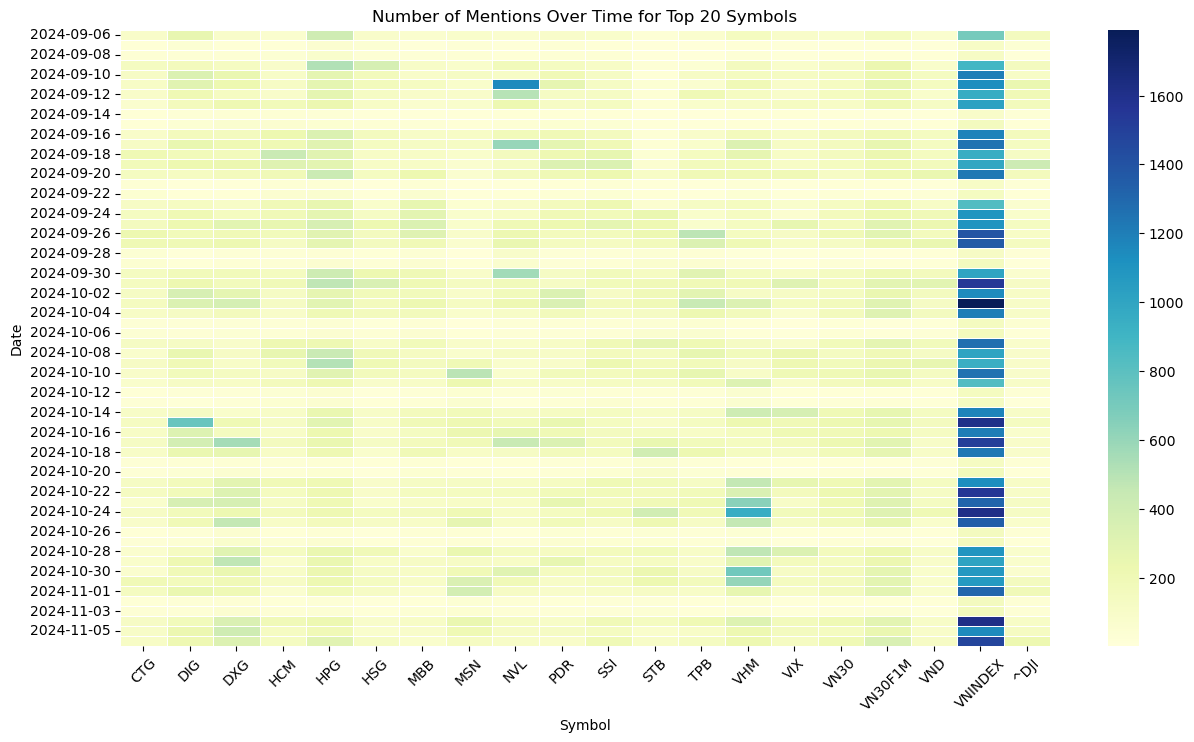

In [234]:
# Filter top 20 symbols based on total number of mentions
top_symbols = symbol_mentions_over_time.groupby('symbol')['number_of_mentions'].sum().nlargest(20).index
top_symbol_data = symbol_mentions_over_time[symbol_mentions_over_time['symbol'].isin(top_symbols)]

# Pivot the data for heatmap
heatmap_data = top_symbol_data.pivot_table(index='date', columns='symbol', values='number_of_mentions', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Number of Mentions Over Time for Top 20 Symbols')
plt.xlabel('Symbol')
plt.ylabel('Date')
plt.xticks(rotation=45)
plt.show()

In [235]:
posts_df['hour'] = posts_df['time'].dt.hour  # Extract the hour from the date
activity_by_hour = posts_df.groupby('hour').agg(
    number_of_posts = ('postID', 'count'),
    average_posts_len = ('word_count', 'mean'),
    total_likes = ('totalLikes', 'sum'),
    total_replies = ('totalReplies', 'sum')
).reset_index()

In [236]:
activity_by_hour = activity_by_hour.round(2)
activity_by_hour.head(2)

hour  number_of_posts  average_posts_len  total_likes  total_replies
0     0             2830             129.89         7230           8790
1     1             1184             128.18         2695           4461

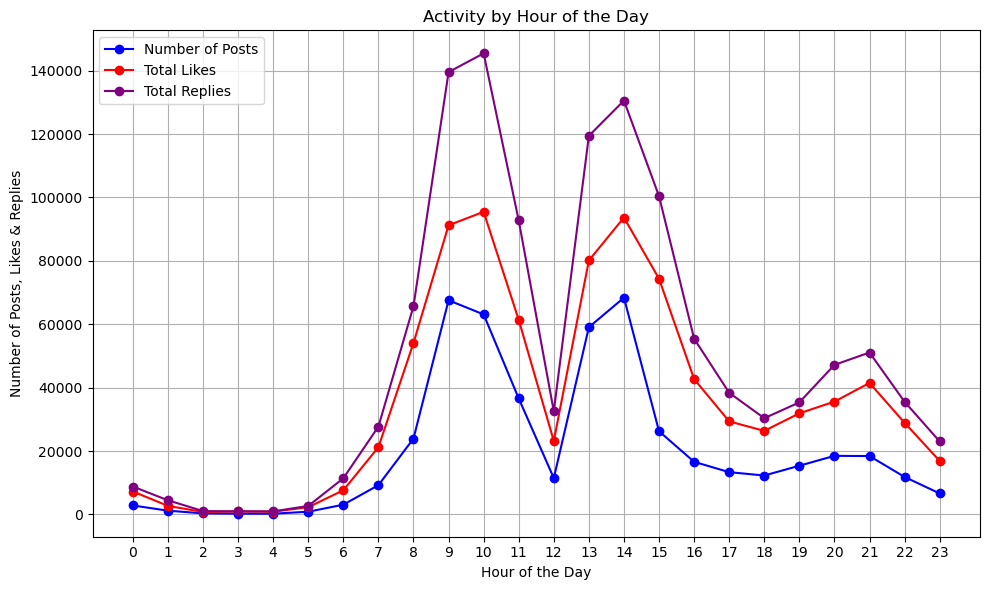

In [237]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot the three metrics (number_of_posts, total_likes, total_replies) on the primary y-axis
plt.plot(activity_by_hour['hour'], activity_by_hour['number_of_posts'], marker='o', label='Number of Posts', color='blue')
plt.plot(activity_by_hour['hour'], activity_by_hour['total_likes'], marker='o', label='Total Likes', color='red')
plt.plot(activity_by_hour['hour'], activity_by_hour['total_replies'], marker='o', label='Total Replies', color='purple')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Posts, Likes & Replies')
plt.title('Activity by Hour of the Day')

# Customize ticks and grid
plt.xticks(range(24))
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [238]:
list_stock_df = pd.read_csv('list_stock.csv')
list_stock_df.head(2)

symbol                                 name  indus_code  \
0    ACB  Ngân hàng Thương mại Cổ phần Á Châu        8300   
1    ATB             Công ty Cổ phần An Thịnh        2300   

             indus_name    exc  m_stholder  m_employee  r_tcbsrating  year  \
0             Ngân hàng   HOSE       60034       13110           3.0  2023   
1  Xây dựng và Vật liệu  UPCOM        1088           4          -1.0  2023   

          m_cap       m_share      r_pb      r_pe        r_eps        r_bvps  \
0  9.671285e+13  3.884050e+09  1.362998  6.181816  4130.928116  18268.547957   
1  8.233212e+09  1.388400e+07  0.236486 -2.193486  -270.345873   2507.544704   

      p_roe     p_div  
0  0.247997  0.040161  
1 -0.102304  0.000000

---
### Advanced analysis and calculations

In [239]:
symbol_groups = posts_df.groupby('symbol')

symbols_data = {symbol : data for symbol, data in symbol_groups}
symbols_data

{'$AAVE':           postID                                    originalContent  \
 73478   28938964                       Short mạnh thôi người anh em   
 149123  28772283  Cập nhật 21h tối 19/10: Btc điều chỉnh làm các...   
 194720  28668837  Cập nhật 15/10: Aave thể hiện Leader của TT. B...   
 204687  28646295  Cập nhật sáng 14/10: Sau ngày giông  bão Btc đ...   
 207559  28641291  Cập nhật 13/10: Aave đã lấy lại ma20 ngày, tạo...   
 259738  28521514  Hôm nay 7/10 Aave đang đi đúng lộ trình tăng d...   
 263306  28513308  Aave bật lên mạnh mẽ ngày 3,4/10 sau đó test l...   
 274410  28487475  19h31 ngày 3/10/2024 Aave phát tín hiệu mua lê...   
 286796  28460125  Á **, sáng vừa khen xong, tối ép cho tè dầm lu...   
 294303  28441891  Qua Iran bem Israel lần 2 mà Aave chỉ rơi về 1...   
 400644  28202043            AAVE canh 90-100 múc, sẽ có giá 280-300   
 433387  28129028                               Éo có lực nâng luôn    
 441002  28111475  Lên đúng 160 rồi đứt chứ không chịu 

In [240]:
symbols_data['$AAVE'].head(2)

postID                                    originalContent  \
73478   28938964                       Short mạnh thôi người anh em   
149123  28772283  Cập nhật 21h tối 19/10: Btc điều chỉnh làm các...   

                                   time        date  link sentiment  \
73478  2024-10-29 12:46:20.700000+07:00  2024-10-29  <NA>   neutral   
149123 2024-10-19 21:04:18.310000+07:00  2024-10-19  <NA>   neutral   

        totalLikes  totalReplies  replyToPostID  \
73478            0             0            NaN   
149123           0             0            NaN   

                             taggedSymbols         username  \
73478   {'symb': '$AAVE', 'price': 153.62}  Bàn Tay Vô Hình   
149123  {'symb': '$AAVE', 'price': 158.86}              geo   

                                      userid  totalImages  totalSymbols  \
73478   2d980e79-7b61-4ac7-9ad6-6aa20a217b2b            0             1   
149123  d9f30fe7-0be1-457f-8cda-f48b83c3342c            0             1   

         price symbol  word_count  hour  
73478   153.62  $AAVE           6    12  
149123  158.86  $AAVE          32    21

### Data Processing and Aggregation for Stock Symbol: Combining Social Media Post Data and Stock Price Changes 

In [241]:
import re
import os
import pandas as pd
from dateutil.parser import isoparser
import warnings

# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def to_post_analysis_dataframe(symbol_name):
    """
    Processes post data for a given stock symbol, aggregating daily posts data
    and merging it with the daily price changes from price data.
    
    Parameters:
    symbol_name (str): The stock symbol name.
    
    Returns:
    pd.DataFrame: DataFrame containing daily aggregated post data and price change information.
    """
    # Filter out non-alphabet characters to find the corresponding file
    cleaned_symbol_name = re.sub(r'[^a-zA-Z0-9]', '', symbol_name)
    file_path = f"price/{cleaned_symbol_name}.csv"

    # Check if price file exists
    if not os.path.exists(file_path):
        return None

    # Sort symbol data by time and calculate price change
    symbol_data_frame = symbols_data[symbol_name]
    symbol_data_frame = symbol_data_frame.sort_values(by='time', ascending=True)
    symbol_data_frame['price_change'] = symbol_data_frame['price'].diff()
    
    # Import price data for each traded period
    price_data_frame = pd.read_csv(file_path)
    price_data_frame['time'] = price_data_frame['time'].astype('string')
    price_data_frame['time'] = price_data_frame['time'].apply(
        lambda x: isoparser().isoparse(x) if pd.notnull(x) else pd.NaT
    )
    price_data_frame['date'] = price_data_frame['time'].dt.date

    # Calculate daily price change
    daily_change = price_data_frame.groupby('date').apply(
        lambda x : pd.Series({
            'open' : x['open'].iloc[0],
            'high' : x['high'].max(),
            'close' : x['close'].iloc[-1],
            'daily_change' : x['close'].iloc[-1] - x['open'].iloc[0]
        })
    ).reset_index()
    
    # Aggregate post data for each date related to the symbol
    posts_analyze_symbol = symbols_data[symbol_name].groupby('date').agg(
        number_of_posts=('postID', 'count'),
        number_of_positive_posts=('sentiment', lambda x: (x == 'positive').sum()),
        number_of_negative_posts=('sentiment', lambda x: (x == 'negative').sum()),
        average_posts_len=('word_count', 'mean'),
        total_likes=('totalLikes', 'sum'),
        total_replies=('totalReplies', 'sum'),
    ).reset_index()

    # Round results and sort by date
    posts_analyze_symbol = posts_analyze_symbol.round(2)
    posts_analyze_symbol = posts_analyze_symbol.sort_values(by='date', ascending=True)

    # Merge posts data with daily price changes, keeping all dates from the price data
    posts_analyze_symbol = posts_analyze_symbol.merge(
    daily_change[['date', 'open', 'high', 'close', 'daily_change']],
    on='date', 
    how='right'
    ).fillna(0)

    # Fill any missing values with 0
    
    
    return posts_analyze_symbol


### Explanation:
Function: to_post_analysis_dataframe
This function processes social media post data and stock price data for a given stock symbol, then combines them into a single DataFrame with daily statistics. It includes aggregations of daily post information and daily price changes.

Parameters:
symbol_name (str): The stock symbol name for which data will be processed.
Returns:
pd.DataFrame: A DataFrame that includes daily aggregated post statistics and stock price information. If the price data file for the symbol does not exist, the function returns None.
Steps:
File Path and Validation:

Strips any non-alphanumeric characters from the symbol_name to form a standardized file path for the stock’s price data (price/{symbol}.csv).
Checks if the price data file exists. If not, the function returns None.
Sort and Calculate Price Changes:

Sorts the DataFrame symbol_data_frame by time in ascending order.
Adds a new column, price_change, representing the day-to-day change in price.
Price Data Processing:

Imports the price data file and parses the time column into a datetime format.
Groups data by date, calculating:
Opening price (open), highest price of the day (high), closing price (close), and daily_change (difference between close and open).
Post Data Aggregation:

Groups the social media posts by date and aggregates:
Total number of posts (number_of_posts).
Number of positive posts (number_of_positive_posts).
Number of negative posts (number_of_negative_posts).
Average post length (average_posts_len).
Total likes and replies.
Data Merging:

Merges the post data and price change data based on date, retaining all dates from the price data to ensure a continuous timeline.
Any missing values are filled with 0 to handle dates with no post activity.

### Symbol Data Aggregation and Validation: Combining Post Data and Stock Price Analysis for Multiple Symbols

In [242]:
symbols_list = [symbol for symbol in posts_df['symbol'].unique() if symbol is not None]
symbols_posts_data = {symbol : to_post_analysis_dataframe(symbol) for symbol in symbols_list}


# Filter out symbols where the data is None
valid_symbols = {symbol: data for symbol, data in symbols_posts_data.items() if data is not None}
invalid_symbols = [symbol for symbol in symbols_posts_data if symbols_posts_data[symbol] is None]

# Print success message
print(f"Successfully created analysis data for {len(valid_symbols)} symbols.")

# Optionally, print the list of invalid symbols if needed
if invalid_symbols:
    print(f"Could not find data for the following symbols: {', '.join(invalid_symbols)}")

Successfully created analysis data for 1157 symbols.
Could not find data for the following symbols: US.VFS, GC=F, UPINDEX, ^IXIC, CL=F, GCB, BTC-USD, YM=F, VNI, BZ=F, NG=F, ZLEH25, ZLEK25, ZLEZ24, ZSEF25, ZSEH25, ZSEK25, ZCEH25, ZCEZ24, ZMEZ24, ZWAZ24, CLEF25, CPEZ24, ZMEH25, PLEF25, SIEZ24, ZWAH25, TKG, CPEH25, CPEK25, SIEF25, SIEH25, SIEK25, CLEZ24, QOF25, ^FTSE, ^GSPC, ^KS11, VN30F1Q, VN30F2Q, CLEG25, CLEH25, PLEJ25, CJC, DZM, LCD, MES, CMWG2314, MQIH25, MQIK25, MQIZ24, SILF25, SILH25, SILK25, ^SSE, ROS, CVPB2403, HAI, SDJ, NQ=F, PLEN25, CCEH25, CCEK25, CCEN25, CCEZ24, SILZ24, ETH-USD, SBEH25, FLC, $BNX, $WLD, ZWAK25, ZWAN25, MCC, FUEBFVND, $PAXG, $BCH, LRCH25, MHGH25, MHGZ24, $TROY, LRCF25, DAG, SBEK25, SBEN25, AMD, KCEH25, LRCK25, TAN, MHGK25, MQCH25, MQCK25, MQCZ24, HVG, CMSN2317, CTC, KCEZ24, MCLEF25, $OP, SJF, XWH25, XWK25, XWZ24, XBF25, XBH25, XBK25, ZMEF25, CPH, ^FCHI, STL, STS, SSF, ZMEK25, ^GDAXI, NAC, ES=F, MDA, IBC, $WBTC, $FORTH, ZCEN25, CTEZ24, ZCEK25, $OG, CTEH25, CTEK

### Advanced Analysis Techniques

- **Bayesian Inference**
- **Markov Chains**
- **Monte Carlo Simulation**
- **Hypothesis Testing**
  - *t-test*
  - *Chi-square test*
- **Expectation-Maximization (EM) Algorithm**
- **Conditional Probability and Independence Testing**
- **Time Series Analysis**
- **Kullback-Leibler (KL) Divergence**
- **Correlation and Causality**
  - *Granger Causality*
- **Multivariate Distributions**
- **Entropy and Information Theory**

### 1. Bayesian Inference

In [243]:
# check if data in price folders are loaded successfully
symbols_posts_data['VNINDEX'].head(2)

date  number_of_posts  number_of_positive_posts  \
0  2024-09-04              0.0                       0.0   
1  2024-09-05              0.0                       0.0   

   number_of_negative_posts  average_posts_len  total_likes  total_replies  \
0                       0.0                0.0            0              0   
1                       0.0                0.0            0              0   

      open     high    close  daily_change  
0  1273.86  1277.27  1275.80          1.94  
1  1276.46  1282.21  1268.21         -8.25

### Create probability_bayesian_inference_posts Function
Calculates the conditional probabilities of stock price changes (up, down, stable) based on post activity levels (high, moderate, low) using Bayesian inference. Takes columns for dates, price changes, and post counts as inputs, and returns a dictionary of probabilities.

In [244]:
def probability_bayesian_inference_posts(date_column, price_column, posts_column):
    # Retrieve the data frame for the given stock symbol
    symbol_data_frame = pd.DataFrame({
        'date' : date_column,
        'daily_change' : price_column,
        'number_of_posts' : posts_column
    })
    
    # handle NULL case
    if symbol_data_frame is None:
        return 'Data not found for the given symbol.' 
    
    # Calculate the number of traded days (unique dates)
    number_traded_days = symbol_data_frame['date'].nunique()
    
    # Calculate the prior probabilities for price movements (up, down, stable)
    prior_price_up = (symbol_data_frame['daily_change'] > 0).sum() / number_traded_days
    prior_price_drop = (symbol_data_frame['daily_change'] < 0).sum() / number_traded_days
    prior_price_stable = (symbol_data_frame['daily_change'] == 0).sum() / number_traded_days
    
    # Calculate the average and standard deviation of posts per day
    mean_posts = symbol_data_frame['number_of_posts'].mean()
    std_dev_posts = symbol_data_frame['number_of_posts'].std()
    
    # Define the thresholds for categorizing the number of posts (low, high, normal)
    low_threshold = max(0, mean_posts - std_dev_posts)  # Low posts: below one standard deviation
    high_threshold = mean_posts + std_dev_posts         # High posts: above one standard deviation
  
    # Calculate the number of days for each activity category (high, low, normal posts)
    high_activity_days = (symbol_data_frame['number_of_posts'] > high_threshold).sum()
    low_activity_days = (symbol_data_frame['number_of_posts'] < low_threshold).sum()
    normal_activity_days = number_traded_days - high_activity_days - low_activity_days
    
    # Calculate the probabilities of high, low, and normal posting activity
    high_activity_prob = high_activity_days / number_traded_days if number_traded_days > 0 else 0
    low_activity_prob = low_activity_days / number_traded_days if number_traded_days > 0 else 0
    normal_activity_prob = 1 - high_activity_prob - low_activity_prob
    
    # Calculate the probabilities of different combinations of posts and price movements for each category
    # Case 1: High number of posts
    P_high_posts_and_price_up = ((symbol_data_frame['number_of_posts'] > high_threshold) 
                                 & (symbol_data_frame['daily_change'] > 0)).sum() / number_traded_days
    P_high_posts_and_price_down = ((symbol_data_frame['number_of_posts'] > high_threshold) 
                                   & (symbol_data_frame['daily_change'] < 0)).sum() / number_traded_days
    P_high_posts_and_price_stable = ((symbol_data_frame['number_of_posts'] > high_threshold) 
                                     & (symbol_data_frame['daily_change'] == 0)).sum() / number_traded_days
    
    # Case 2: Low number of posts
    P_low_posts_and_price_up = ((symbol_data_frame['number_of_posts'] < low_threshold) 
                                 & (symbol_data_frame['daily_change'] > 0)).sum() / number_traded_days
    P_low_posts_and_price_down = ((symbol_data_frame['number_of_posts'] < low_threshold) 
                                   & (symbol_data_frame['daily_change'] < 0)).sum() / number_traded_days
    P_low_posts_and_price_stable = ((symbol_data_frame['number_of_posts'] < low_threshold) 
                                     & (symbol_data_frame['daily_change'] == 0)).sum() / number_traded_days
    
    # Case 3: Moderate number of posts (between low and high thresholds)
    P_moderate_posts_and_price_up = (
        ((symbol_data_frame['number_of_posts'] >= low_threshold) & 
        (symbol_data_frame['number_of_posts'] <= high_threshold) & 
        (symbol_data_frame['daily_change'] > 0)).sum() / number_traded_days
    )
    P_moderate_posts_and_price_down = (
        ((symbol_data_frame['number_of_posts'] >= low_threshold) & 
        (symbol_data_frame['number_of_posts'] <= high_threshold) & 
        (symbol_data_frame['daily_change'] < 0)).sum() / number_traded_days
    )
    P_moderate_posts_and_price_stable = (
        ((symbol_data_frame['number_of_posts'] >= low_threshold) & 
        (symbol_data_frame['number_of_posts'] <= high_threshold) & 
        (symbol_data_frame['daily_change'] == 0)).sum() / number_traded_days
    )
        
    # Now, calculate the conditional probabilities P(Posts | Price Change) using Bayes' theorem
    # For each price change category (up, down, stable), calculate the conditional probabilities
    
    # Calculate P(High Posts | Price changes)
    # Follow the formula: P(High Posts | Price Up) = P(High Posts and Price Up) / P(Price changes)
    P_high_posts_given_price_up = P_high_posts_and_price_up / prior_price_up if prior_price_up > 0 else 0
    P_high_posts_given_price_down = P_high_posts_and_price_down / prior_price_drop if prior_price_drop > 0 else 0
    P_high_posts_given_price_stable = P_high_posts_and_price_stable / prior_price_stable if prior_price_stable > 0 else 0
    
    # Calculate P(Moderate Posts | Price Up)
    # Follow the formula: P(Moderate Posts | Price Up) = P(Moderate Posts and Price changes) / P(Price changes)
    P_moderate_posts_given_price_up = P_moderate_posts_and_price_up / prior_price_up if prior_price_up > 0 else 0
    P_moderate_posts_given_price_down = P_moderate_posts_and_price_down / prior_price_drop if prior_price_drop > 0 else 0
    P_moderate_posts_given_price_stable = P_moderate_posts_and_price_stable / prior_price_stable if prior_price_stable > 0 else 0
    
    # Calculate P(Low Posts | Price Up)
    # Follow the formula: P(Low Posts | Price Up) = P(Low Posts and Price changes) / P(Price changes)
    P_low_posts_given_price_up = P_low_posts_and_price_up / prior_price_up if prior_price_up > 0 else 0
    P_low_posts_given_price_down = P_low_posts_and_price_down / prior_price_drop if prior_price_drop > 0 else 0
    P_low_posts_given_price_stable = P_low_posts_and_price_stable / prior_price_stable if prior_price_stable > 0 else 0
    
    # Calculate the final probabilities for price changes given high, moderate, and low posts
    # Follow the formula: P(Price changes | Posts) = [P(Posts | Price changes) * P(Price changes)] / P(Posts)
    P_price_up_given_high_posts = (P_high_posts_given_price_up * prior_price_up) / high_activity_prob if high_activity_prob > 0 else 0
    P_price_down_given_high_posts = (P_high_posts_given_price_down * prior_price_drop) / high_activity_prob if high_activity_prob > 0 else 0
    P_price_stable_given_high_posts = (P_high_posts_given_price_stable * prior_price_stable) / high_activity_prob if high_activity_prob > 0 else 0

    P_price_up_given_moderate_posts = (P_moderate_posts_given_price_up * prior_price_up) / normal_activity_prob if normal_activity_prob > 0 else 0
    P_price_down_given_moderate_posts = (P_moderate_posts_given_price_down * prior_price_drop) / normal_activity_prob if normal_activity_prob > 0 else 0
    P_price_stable_given_moderate_posts = (P_moderate_posts_given_price_stable * prior_price_stable) / normal_activity_prob if normal_activity_prob > 0 else 0

    P_price_up_given_low_posts = (P_low_posts_given_price_up * prior_price_up) / low_activity_prob if low_activity_prob > 0 else 0
    P_price_down_given_low_posts = (P_low_posts_given_price_down * prior_price_drop) / low_activity_prob if low_activity_prob > 0 else 0
    P_price_stable_given_low_posts = (P_low_posts_given_price_stable * prior_price_stable) / low_activity_prob if low_activity_prob > 0 else 0

    # Return the final conditional probabilities for each scenario
    return {
    "P(Price Up | High Posts)": round(P_price_up_given_high_posts, 4),
    "P(Price Down | High Posts)": round(P_price_down_given_high_posts, 4),
    "P(Price Stable | High Posts)": round(P_price_stable_given_high_posts, 4),
    
    "P(Price Up | Moderate Posts)": round(P_price_up_given_moderate_posts, 4),
    "P(Price Down | Moderate Posts)": round(P_price_down_given_moderate_posts, 4),
    "P(Price Stable | Moderate Posts)": round(P_price_stable_given_moderate_posts, 4),
    
    "P(Price Up | Low Posts)": round(P_price_up_given_low_posts, 4),
    "P(Price Down | Low Posts)": round(P_price_down_given_low_posts, 4),
    "P(Price Stable | Low Posts)": round(P_price_stable_given_low_posts, 4)
}


In [245]:
VNINDEX_posts_df = symbols_posts_data['VNINDEX']

P_VNINDEX_number_of_posts = probability_bayesian_inference_posts(VNINDEX_posts_df['date'], VNINDEX_posts_df['daily_change'], VNINDEX_posts_df['number_of_posts'])
P_VNINDEX_number_positive_posts = probability_bayesian_inference_posts(VNINDEX_posts_df['date'], VNINDEX_posts_df['daily_change'], VNINDEX_posts_df['number_of_positive_posts'])
P_VNINDEX_number_negative_posts = probability_bayesian_inference_posts(VNINDEX_posts_df['date'], VNINDEX_posts_df['daily_change'], VNINDEX_posts_df['number_of_negative_posts'])

### Heatmap Illustration function: Probability of Price Changes in VNINDEX

In [246]:
def plot_probability_heatmap(dict_data, title):
    matrix = [[dict_data['P(Price Up | High Posts)'], dict_data['P(Price Up | Moderate Posts)'], dict_data['P(Price Up | Low Posts)']],
              [dict_data['P(Price Stable | High Posts)'], dict_data['P(Price Stable | Moderate Posts)'], dict_data['P(Price Stable | Low Posts)']],
              [dict_data['P(Price Down | High Posts)'], dict_data['P(Price Down | Moderate Posts)'], dict_data['P(Price Down | Low Posts)']]]
    col_labels = ['High Posts', 'Moderate Posts', 'Low Posts']
    row_labels = ['Price Up', 'Price Stable', 'Price Down']
    
    # Create the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=col_labels, yticklabels=row_labels)
    plt.title(title)
    plt.xlabel('Number of posts')
    plt.ylabel('Changes in price')
    plt.yticks(rotation = 0) 
    plt.show()
 

### Heatmap illustration for the probability of the changes in price pf VNINDEX given number of posts, number of positive posts, number of negative posts

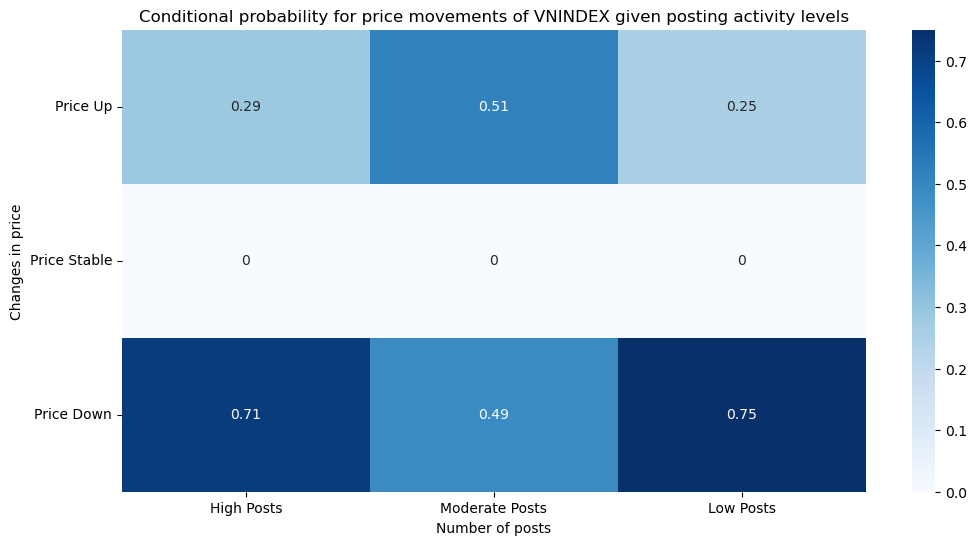

In [247]:
plot_probability_heatmap(P_VNINDEX_number_of_posts, 'Conditional probability for price movements of VNINDEX given posting activity levels')

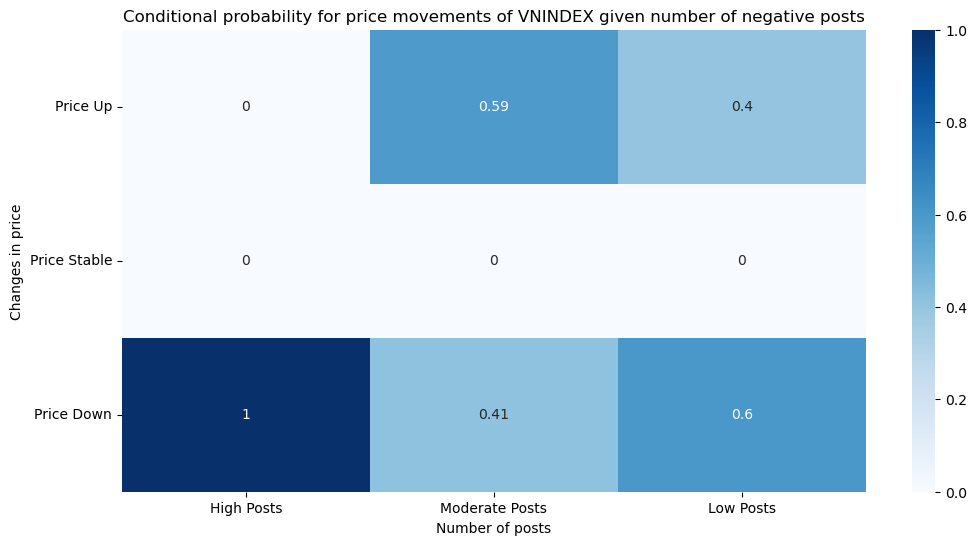

In [248]:
plot_probability_heatmap(P_VNINDEX_number_negative_posts, 'Conditional probability for price movements of VNINDEX given number of negative posts')

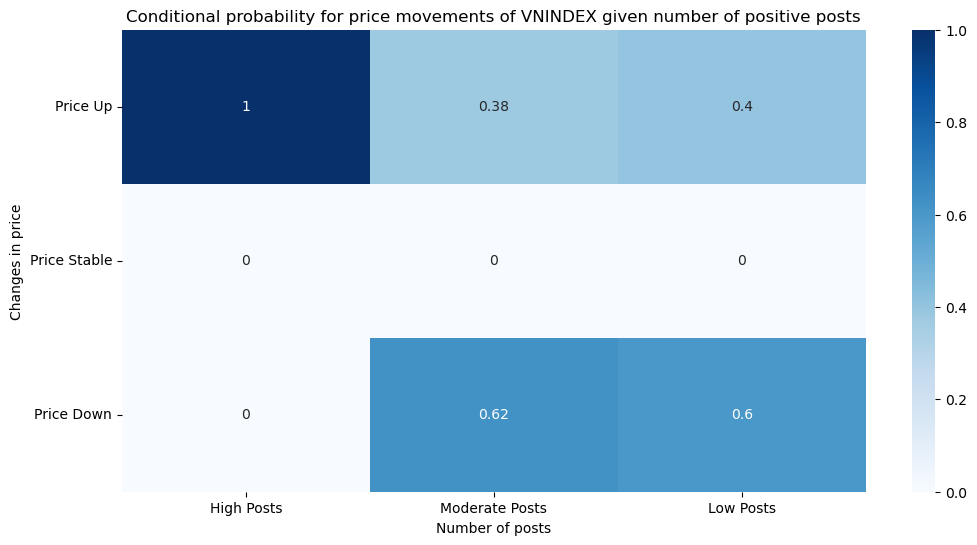

In [249]:
plot_probability_heatmap(P_VNINDEX_number_positive_posts, 'Conditional probability for price movements of VNINDEX given number of positive posts')

### Create a function to convert probability in the dict into a matrix

In [250]:
import pandas as pd

def dict_to_matrix(data):
    # Extract row and column labels from keys
    rows = sorted(set(key.split(" | ")[0].replace("P(", "") for key in data.keys()))
    columns = sorted(set(key.split(" | ")[1].replace(")", "") for key in data.keys()))
    
    # Create an empty DataFrame with rows as index and columns as columns
    matrix_df = pd.DataFrame(index=rows, columns=columns)
    
    # Populate the DataFrame with values from the dictionary
    for key, value in data.items():
        row_label = key.split(" | ")[0].replace("P(", "")
        col_label = key.split(" | ")[1].replace(")", "")
        matrix_df.loc[row_label, col_label] = value

    # Convert the DataFrame to a matrix (NumPy array) and fill NaN with 0 if needed
    matrix = matrix_df.fillna(0).values  # .fillna(0) is used to replace any missing values with 0

    return matrix_df, matrix

data = P_VNINDEX_number_positive_posts
matrix_df, matrix = dict_to_matrix(data)

print("DataFrame:\n", matrix_df)
print("\nMatrix:\n", matrix)


DataFrame:
              High Posts Low Posts Moderate Posts
Price Down          0.0       0.6         0.6216
Price Stable        0.0       0.0            0.0
Price Up            1.0       0.4         0.3784

Matrix:
 [[0.     0.6    0.6216]
 [0.     0.     0.    ]
 [1.     0.4    0.3784]]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22252\336377204.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix_df.fillna(0).values  # .fillna(0) is used to replace any missing values with 0
